# Real-Time fMRI Analysis

Typically when we run fMRI experiments we create a sequence of stimuli or events we want to show the participant and then observe their brain activity in response to these pre-specified events. This allows for an assessment of the correlation between tasks and BOLD activity, which limits the causal interpretability. Real-time is a step in the direction of drawing causal inferences with fMRI. Specifically, rather than just being a dependent variable, brain activity becomes part of the design as a kind of independent variable.

Take for instance a real-time experiment like [deBettencourt et. al., (2015)](http://ntblab.yale.edu/wp-content/uploads/2015/03/deBettencourt_NN_2015.pdf). In this case the brain activity was used to make the task easier or harder depending on the participant's attentional state, with the goal of training them to attend better. However, if the brain activity was too noisy or analyzed inappropriately, read out from brain regions that didn't contain information about attentional state, or taken from another participant's brain (as in the control condition), then the participant should not improve.

There are no second chances with real-time fMRI because your analysis is part of data collection. For example, you can't decide to use a different preprocessing step, classifier algorithm, parameter setting, etc. after the fact. This is why preparation, piloting, and efficient code is critical for real time.


## Goal of this script
    1. Learn to design a real-time fMRI experiment  
    2. Run a real-time fMRI analysis using simulated data  


## Table of Contents
[1. The Real-Time Workflow](#rt_wf)  
>[1.1 Data File Preparation](#data_prep)  
>[1.2 File Watcher](#file-watch)   
>[1.3 Preprocess TR](#preprocess-tr)  
>[1.4 Training A Model](#real-time-train)  
>[1.5 Classifying New Volumes](#real-time-test)  
>[1.6 Modify Stimulus After Classification](#mod-stim)  
  
[2. Running a Real-Time Simulation](#real-time-sim)

[3. Adaptive Real-Time Experiments](#real-time-change)


Exercises
1. [Exercise 1](#ex1)  
2. [Exercise 2](#ex2)  
3. [Exercise 3](#ex3)  
4. [Exercise 4](#ex4)  
5. [Exercise 5](#ex5)  
6. [Exercise 6](#ex6)  
7. [Exercise 7](#ex7)  
8. [Exercise 8](#ex8)   
[Novel contribution](#novel)  

## 1. The Real-Time Workflow <a id="rt_wf"></a>

The following sequence of steps are necessary for successfully running a real-time fMRI Analysis. 

1. [Data File Preparation](#data_prep): Setup a folder where fMRI volumes will be stored as they are created.
        
2. [File Watcher](#file-watch): A function that looks for a volume to process.

3. [Preprocess TR](#preprocess): Preprocess the TR to prepare it for classification

4. [Training A Model](#real-time-train): Take the data you have set aside for training and create your classifier model.

4. [Classifying New Volumes](#real-time-test): Take an epoch of data and classify that, assigning it a label.

6. [Modify Stimulus After Classification](#mod-stim) The classifier results influence the next stimulus shown to the participant.

Here is one example pipeline:

![alt text](https://media.nature.com/m685/nature-assets/neuro/journal/v18/n3/images/nn.3940-F1.jpg)


In [2]:
import os
import time
import numpy as np  # type: ignore
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression  # type: ignore
from watchdog.events import PatternMatchingEventHandler  # type: ignore
from watchdog.observers import Observer  # type: ignore
from queue import Queue
from sklearn import svm
from sklearn import linear_model
import scipy.stats
from IPython import display

### 1.1 Data file preparation <a id="data_prep"></a>

As you know, an fMRI data volume is generated for each TR. The scanner outputs these files one-by-one in DICOM format. You will first need to read the DICOM data into a numpy array. The code below will then process the numpy array. One way to read DICOM files into numpy is by using the package [dicom-numpy](http://dicom-numpy.readthedocs.io/en/latest/).

For this notebook, we will generate simulated data using the *brainiak.fmrism* package. The function *generate_data.py* simulates a two condition experiment where each condition is blocked for 10s with no ISI between events. More specifically, this function simulates fMRI noise and then inserts signal in two regions corresponding to the two conditions with the appropriate HRF. 

**Self-Study:** Investigate the *generate_data.py* function to learn how it is working and what brain activity distinguishes between conditions.

**Exercise 1:**<a id="ex1"></a> How is *generate_data.py* deciding the order of the two conditions? Is this how you would design an fMRI study? If not, modify the script to what you think is a better design.


**A:** Currently, the generate_data.py function "flips a coin" to decide on whether the condition in a given block is A or B. This could easily lead to an unequal number of blocks of each type, which is *not* how I would design an fMRI study. I have modified the script to interleave trials in groups of two. This ensures that each subject sees an equal number of A and B trials, and also that the lag in the signal (up to 6 seconds!) doesn't contaminate a huge amount of each block.


To simulate real time data, this function outputs a TR every 2s and saves it as a numpy matrix in the *fmrisim/data/* folder. To run the script, run the cell below:

In [3]:
# Run the generate_data function
!sbatch run_generate_data.sh

Submitted batch job 1344480


Any time you want to simulate the acquisition of data you should delete the contents of this folder (rm fmrisim/data/\*) and then run it again.

Below we will set the paths to be used. We also want to specify the proportion of trials that will be used for training the model (time until the real-time neurofeedback kicks in).

In [4]:
input_dir = './fmrisim/' # Where is information stored that is needed for generating data
data_dir = input_dir + 'data/'
file_pattern = 'rt_{0:0>3}.npy'  # What is the pattern of file that wil be created

train_count = 40 # Number of trials that will be used for training. 

### 1.2 File watcher <a id="file-watch"></a>

For real time, we want to monitor as every TR comes in. The simple way to do this is to just set up a loop which checks whether the file exists and waits until it does, the loop below does this.

In [5]:
# Create a file watching algorithm
def tr_watcher_simple(filename,
                      sleep_time=0.1,
                     ):
    
    # While the file doesn't exist, loop and wait
    while not os.path.exists(filename):
        time.sleep(sleep_time)  # How long do you want to wait for
        
    # When the file exists, load it and output it
    vol = np.load(filename)
    
    return vol

However, this procedure is prone to error and is inefficient. For instance, if a volume is added just after a check, this code waits the sleep window before checking again. Moreover, this procedure can crash since the file names often exist before the file contents are created (and so if they are read in too soon then the code may crash).

Instead, to process volumes as soon as they are finished being created, a file watcher function continuously polls for new files. Once a new file is found, it is added to a queue and triggers a call to the next processing step. The 'watchdog' package is used for ths purpose.

In [6]:
# Create a file watching algorithm
def tr_watcher(filename, file_queue):
    
    # Does the file exist?
    file_exists = os.path.exists(filename)
    
    # While the file doesn't exist, loop and wait
    while not file_exists:
        
        # look for file creation event
        event = file_queue.get()
        
        # If there is an event then save it
        if event.src_path == filename:
            file_exists = True
    
    # When the file exists, load it and output it
    vol = np.load(filename)
    
    return vol


# Create a class of events for 
class file_notify_handler(PatternMatchingEventHandler):

    # Initialize the object being created
    def __init__(self, queue, file_pattern):
        super().__init__(patterns=file_pattern)
        self.q = queue
    
    # When an event occurs, put it in the queue
    def on_created(self, event):
        self.q.put(event)
        

We are going to check out this file watcher in action. Remember to clear your fmrisim/data directory and re-launch *generate_data*. This script will first play catch up and then print every time a new TR comes in until the training set is acquired.

In [8]:
file_observer = Observer()
file_queue = Queue()  # type: ignore

# set up the notifications for when a new TR is created
notify_file_pattern = '*.npy'  
file_notify = file_notify_handler(file_queue, [notify_file_pattern])  
file_observer.schedule(file_notify, data_dir, recursive=False)  
file_observer.start()  

for idx in range(train_count): 

    # What file name are you going to load
    next_filename = data_dir + file_pattern.format(idx) 
    vol = tr_watcher(next_filename, file_queue)

    # When the file exists, load it and output it
    print('Recieved:', next_filename)
    
file_observer.stop()

Recieved: ./fmrisim/data/rt_000.npy
Recieved: ./fmrisim/data/rt_001.npy
Recieved: ./fmrisim/data/rt_002.npy
Recieved: ./fmrisim/data/rt_003.npy
Recieved: ./fmrisim/data/rt_004.npy
Recieved: ./fmrisim/data/rt_005.npy
Recieved: ./fmrisim/data/rt_006.npy
Recieved: ./fmrisim/data/rt_007.npy
Recieved: ./fmrisim/data/rt_008.npy
Recieved: ./fmrisim/data/rt_009.npy
Recieved: ./fmrisim/data/rt_010.npy
Recieved: ./fmrisim/data/rt_011.npy
Recieved: ./fmrisim/data/rt_012.npy
Recieved: ./fmrisim/data/rt_013.npy
Recieved: ./fmrisim/data/rt_014.npy
Recieved: ./fmrisim/data/rt_015.npy
Recieved: ./fmrisim/data/rt_016.npy
Recieved: ./fmrisim/data/rt_017.npy
Recieved: ./fmrisim/data/rt_018.npy
Recieved: ./fmrisim/data/rt_019.npy
Recieved: ./fmrisim/data/rt_020.npy
Recieved: ./fmrisim/data/rt_021.npy
Recieved: ./fmrisim/data/rt_022.npy
Recieved: ./fmrisim/data/rt_023.npy
Recieved: ./fmrisim/data/rt_024.npy
Recieved: ./fmrisim/data/rt_025.npy
Recieved: ./fmrisim/data/rt_026.npy
Recieved: ./fmrisim/data/rt_

### 1.3 Preprocess TR <a id="preprocess-tr"></a>

As each volume is received, it is necessary to preprocess it. You will have to make design choices on how to accomplish all preprocessing in an efficient manner so as to process incoming volumes. This preprocessing could involve numerous steps, including motion correction, masking and normalization. The simulator does not generate any motion artifacts so that step is unnecessary. Masking is critical because we don't want to feed the model irrelevant features. Normalization in space (as we will do) is easy because each time point can be treated independently; however, normalizing across time is hard since each additional TR will change the mean and SD, and thus the z-values of all preceding TRs. This is a more general consequence of real-time, wherein you know the past but not the future. This also impacts temporal filtering, which must be done with "causal" filters. For this reason, procedures for normalizing and filtering over time are still being developed/refined.

**Self-study:** Look into normalizing voxels across time. Helpful information is found in the StandardScaler function of sklearn. For temporal filtering, compare the filtfilt and lfilter functions in scipy.

**Exercise 2:** <a id="ex2"></a>  Create a preprocessing function. This function will take in a volume and a mask and then output a 1 dimensional vector of preprocessed voxels. In this function, perform masking and then z-score the masked voxels in space. Finally, reshape the data to be 1-D.

In [9]:
# Insert code here
def preprocess_vol(vol,
                  mask):
    masked = vol[mask == 1]
    #reshaped = masked.reshape(1, -1)
    return scipy.stats.zscore(masked)

**Exercise 3:** <a id="ex3"></a> Do a speed test of the tr watcher and preprocessing functions to make sure they fit within 1 TR. Specifically add to the loop below appropriate time stamping and print commands. Comment on whether this is fast enough.

In [10]:
# This is fast enough!!
    
# load mask
mask_file = input_dir +'mask.npy'
mask = np.load(mask_file)

# allocate a matrix to hold the TR data, preset to NaNs. Each row is a TR vector
tr_data = np.full((train_count, mask.sum()), np.nan)

# set up the notifications for when a new TR is created
file_observer = Observer()
file_queue = Queue()  # type: ignore

notify_file_pattern = '*.npy'  
file_notify = file_notify_handler(file_queue, [notify_file_pattern])  
file_observer.schedule(file_notify, data_dir, recursive=False)  
file_observer.start()  

# Cycle through TRs
for idx in range(train_count): 
    
    # Start the timer
    begin_time = time.time()
    
    # What file name are you going to load
    next_filename = data_dir + file_pattern.format(idx) 
    vol = tr_watcher(next_filename, file_queue)
    
    # Store the volume as a preprocessed vector
    tr_data[idx, :] = preprocess_vol(vol, mask)
    
    # End the timer
    end_time = time.time()
    
    # Print the timing
    print('tr_watcher and preprocessing duration: ' + str(end_time - begin_time))

file_observer.stop()

tr_watcher and preprocessing duration: 0.00341796875
tr_watcher and preprocessing duration: 0.002482891082763672
tr_watcher and preprocessing duration: 0.0021233558654785156
tr_watcher and preprocessing duration: 0.0020928382873535156
tr_watcher and preprocessing duration: 0.0019237995147705078
tr_watcher and preprocessing duration: 0.0019185543060302734
tr_watcher and preprocessing duration: 0.0019071102142333984
tr_watcher and preprocessing duration: 0.0018296241760253906
tr_watcher and preprocessing duration: 0.00182342529296875
tr_watcher and preprocessing duration: 0.001833200454711914
tr_watcher and preprocessing duration: 0.0018231868743896484
tr_watcher and preprocessing duration: 0.0018091201782226562
tr_watcher and preprocessing duration: 0.0017521381378173828
tr_watcher and preprocessing duration: 0.0017402172088623047
tr_watcher and preprocessing duration: 0.0017385482788085938
tr_watcher and preprocessing duration: 0.0017397403717041016
tr_watcher and preprocessing duratio

### 1.4 Training a model  <a id="real-time-train"></a>

After we have collected enough TRs we then train our classifier. Like deBettencourt et al. (2015) we will use an L2 logistic regression. Below a function is created to take in TR by voxel training data and a list of labels for each TR and then fit a regression function to it.

In [20]:
# Train 2 Logistic Regression models
def train_logistic(training_data,
                   training_labels,
                   parameters='l2'):
    
    # Train the model predicting state 2 (so that true means 1 and false means 0)
    clf = LogisticRegression(penalty=parameters)
    clf.fit(training_data, training_labels == 2)

    return clf

A critical step when training the model is shifting the labels. We expect that a stimulus will evoke activity 4-6s after it's onset.

In [21]:
# Load the labels
label_file = data_dir + 'labels.npy'
labels = np.load(label_file)

# How much do you need to shift the labels by in terms of TRs
tr_shift = 3

training_data   = tr_data[tr_shift:train_count, :]
training_labels = labels[0:train_count - tr_shift]

In [22]:
# Fit the model
clf = train_logistic(training_data, training_labels[:,0])

We can now visualize this training in order to see what the model has learned.

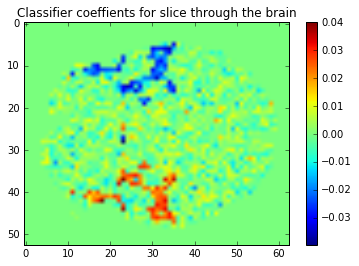

In [23]:
coefs = np.zeros(mask.shape)
coefs[mask==1]=clf.coef_[0,:]

plt.imshow(coefs[:,:,16])
plt.title('Classifier coeffients for slice through the brain')
plt.colorbar()

### 1.5 Classifying new volumes  <a id="real-time-test"></a>

Now that we have trained a model, we want to classify incoming information according to that model. Since most classifiers come with the *.fit* and *.predict* formulation, this is very easy to do (after some reshaping). In the case of a logistic regression, the outcome is simply true or false. In this case, true means condition 2 and false means condition 1. We can then do that for every new TR as it comes in.

In [24]:
# Get a new TR
next_filename = data_dir + file_pattern.format(train_count + 1)
vol = tr_watcher(next_filename, file_queue)

# Store the volume as a preprocessed vector
new_data = preprocess_vol(vol, mask)
prediction = clf.predict(new_data.reshape(1, -1))

print('Prediction for TR %d is condition %d and the label is %d' % (train_count + 1, prediction + 1, labels[idx - tr_shift]))

Prediction for TR 41 is condition 2 and the label is 2


### 1.6 Modifying the stimulus after classification  <a id="mod-stim"></a>

The final step in the real-time analysis is to use the classifier results and provide feedback to the subject in the scanner. This could involve changing the composition of the stimulus, changing the task difficulty or providing feedback directly. Although we won't do this here, it can be easily implemented in any experiment code from Psychtoolbox or PsychoPy.

## 2. Real-Time Simulation  <a id="real-time-sim"></a>

Now that we have all the parts of the real-time workflow, we can put them together to run a simulated real-time experiment. The function below named *realtime* does this. 

This takes as an input the fmrisim directory. It also takes the number of TRs that are used for training and a function which specifies how to run the classifier (e.g. *train_logistic*). The final input *incremental_batch* will be discussed later.

In [25]:
def realtime(input_dir,
             train_count,
             clf_obj=train_logistic,
             incremental_batch=0,
            ):
    
    # Where is the data?
    data_dir = input_dir + 'data/'  
        
    
    # While the file doesn't exist, loop and wait
    label_file = data_dir + 'labels.npy'
    while not os.path.exists(label_file):
        time.sleep(0.1)  # How long do you want to wait for
    
    # load labels
    labels = np.load(label_file)

    # How much do you need to shift the labels by in terms of TRs
    tr_shift = 3
    
    # load mask
    mask_file = input_dir +'mask.npy'
    mask = np.load(mask_file)

    # allocate a matrix to hold the TR data, preset to NaNs. Each row is a TR vector
    tr_data = np.full((len(labels), mask.sum()), np.nan)

    # Set up the figure
    plt.figure()  # Set up figure
    plt.plot((train_count, train_count), (0, 3), 'g')
    plt.xlim((0, len(labels)))
    plt.ylim((0, 3))
    plt.title('Searching for the first TR')
    is_print=0
    
    # set up the notifications for when a new TR is created
    file_observer = Observer()
    file_queue = Queue()  # type: ignore
    
    file_notify = file_notify_handler(file_queue, [notify_file_pattern])  
    file_observer.schedule(file_notify, data_dir, recursive=False)  
    file_observer.start()  

    # Listen for TRs
    num_correct = 0  # Preset the number of correct answers to zero
    for idx in range(len(labels)): 

        # What file name are you going to load
        next_filename = data_dir + file_pattern.format(idx, '02d')  
        vol = tr_watcher(next_filename, file_queue)

        # Store the volume as a preprocessed vector
        tr_data[idx, :] = preprocess_vol(vol, mask)

        plt.plot(range(idx), labels[0:idx], 'r-')

        # Collect TRs for training
        if idx < train_count:
            plt.title('TR: %d for training' % idx)
        elif idx == train_count: # Is this time to train the classifier

            # Train the classifier
            trainStart = time.time()
            plt.title("Sufficient TRs collected, training the model")

            # Train the classifier
            clf = clf_obj(tr_data[tr_shift:train_count, :], labels[0:train_count - tr_shift][:,0])

            # Report the training duration
            print("Completed training in %0.2f sec" % (time.time() - trainStart))

        elif idx > train_count:  # Is this after training (is it testing)

            # Pull out the predictions of the model for this TR
            prediction = clf.predict(tr_data[idx, :].reshape(1, -1))

            # If it is a boolean (0 or 1) then add 1 to turn it into the labels
            if prediction.dtype=='bool':
                prediction = prediction + 1

            if prediction == labels[idx - tr_shift]:
                num_correct += 1

            plt.scatter(idx, prediction)
            plt.title('TR: %d; Total accuracy: %0.2f' % (idx + 1, num_correct / (idx - train_count)))

            # Do you want to create a new batch for training if doing an incremental fit
            if incremental_batch > 0 and np.mod((idx - train_count), incremental_batch) == 0:

                # When does this batch start
                start_idx = idx - incremental_batch

                # Feed in the classifier to be updated with the current batch size
                clf = clf_obj(tr_data[start_idx + tr_shift:idx, :], labels[start_idx:idx - tr_shift], clf)

                # Mark where the new batch was loaded in
                plt.plot((idx, idx), (0, 3), 'k')

        # Plot the figure
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.xlim((0, len(labels)))
        plt.ylim((0, 3))
        
    # Stop listening
    file_observer.stop()

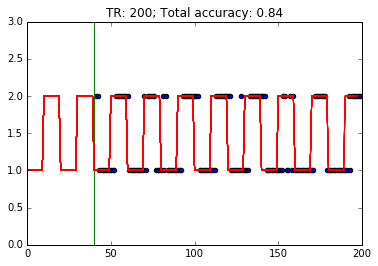

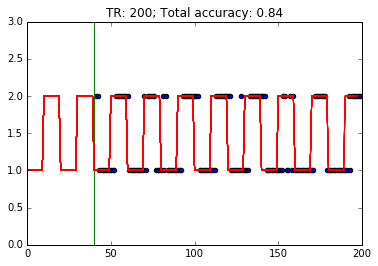

In [26]:
try:
    realtime(input_dir=input_dir,
             train_count=train_count,
             clf_obj=train_logistic,
             incremental_batch=0,
            )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

**Exercise 4:**<a id="ex4"></a> Re-run the *realtime* function using a different classifier. Create a new classifier function with a different kernel and run it below.

In [40]:
def train_SVC(training_data, training_labels):
    
    # Train the model predicting state 2 (so that true means 1 and false means 0)
    clf = svm.SVC(C=100)
    clf.fit(training_data, training_labels)

    return clf

clf = train_SVC(training_data, training_labels[:,0])

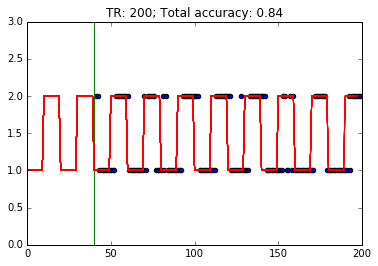

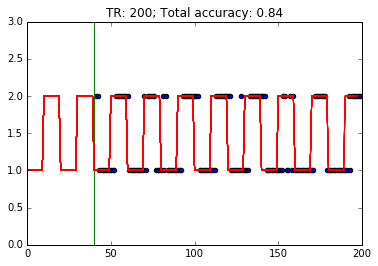

In [41]:
# Run the realtime function with this new classifier object
try:
    realtime(input_dir=input_dir,
             train_count=train_count,
             clf_obj=train_SVC,
             incremental_batch=0,
            )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

**Exercise 5:**<a id="ex5"></a> Create a new copy of the *realtime* function below and rename it. Then edit it in order to plot the classifier decision evidence rather than the labels. Make sure that you have an appropriate classifier that outputs the decision evidence for each prediction (and re-scale your figure appropriately).

In [30]:
def realtime_evidence(input_dir,
             train_count,
             clf_obj=train_logistic,
             incremental_batch=0,
            ):
    
    # Where is the data?
    data_dir = input_dir + 'data/'  
        
    
    # While the file doesn't exist, loop and wait
    label_file = data_dir + 'labels.npy'
    while not os.path.exists(label_file):
        time.sleep(0.1)  # How long do you want to wait for
    
    # load labels
    labels = np.load(label_file)
    labels = (labels * 2) - 3

    # How much do you need to shift the labels by in terms of TRs
    tr_shift = 3
    
    # load mask
    mask_file = input_dir +'mask.npy'
    mask = np.load(mask_file)

    # allocate a matrix to hold the TR data, preset to NaNs. Each row is a TR vector
    tr_data = np.full((len(labels), mask.sum()), np.nan)

    # Set up the figure
    plt.figure()  # Set up figure
    plt.plot((train_count, train_count), (-2, 2), 'g')
    plt.xlim((0, len(labels)))
    plt.ylim((0, 3))
    plt.title('Searching for the first TR')
    is_print=0
    
    # set up the notifications for when a new TR is created
    file_observer = Observer()
    file_queue = Queue()  # type: ignore
    
    file_notify = file_notify_handler(file_queue, [notify_file_pattern])  
    file_observer.schedule(file_notify, data_dir, recursive=False)  
    file_observer.start()  

    # Listen for TRs
    num_correct = 0  # Preset the number of correct answers to zero
    for idx in range(len(labels)): 

        # What file name are you going to load
        next_filename = data_dir + file_pattern.format(idx, '02d')  
        vol = tr_watcher(next_filename, file_queue)

        # Store the volume as a preprocessed vector
        tr_data[idx, :] = preprocess_vol(vol, mask)

        plt.plot(range(idx), labels[0:idx], 'r-')

        # Collect TRs for training
        if idx < train_count:
            plt.title('TR: %d for training' % idx)
        elif idx == train_count: # Is this time to train the classifier

            # Train the classifier
            trainStart = time.time()
            plt.title("Sufficient TRs collected, training the model")

            # Train the classifier
            clf = clf_obj(tr_data[tr_shift:train_count, :], labels[0:train_count - tr_shift][:,0])

            # Report the training duration
            print("Completed training in %0.2f sec" % (time.time() - trainStart))

        elif idx > train_count:  # Is this after training (is it testing)

            # Pull out the predictions of the model for this TR
            evidence = clf.decision_function(tr_data[idx, :].reshape(1, -1))
            
            """
            # If it is a boolean (0 or 1) then add 1 to turn it into the labels
            if prediction.dtype=='bool':
                prediction = prediction + 1

            if prediction == labels[idx - tr_shift]:
                num_correct += 1
            """

            plt.scatter(idx, evidence)
            plt.title('Evidence')

            # Do you want to create a new batch for training if doing an incremental fit
            if incremental_batch > 0 and np.mod((idx - train_count), incremental_batch) == 0:

                # When does this batch start
                start_idx = idx - incremental_batch

                # Feed in the classifier to be updated with the current batch size
                clf = clf_obj(tr_data[start_idx + tr_shift:idx, :], labels[start_idx:idx - tr_shift], clf)

                # Mark where the new batch was loaded in
                plt.plot((idx, idx), (0, 3), 'k')

        # Plot the figure
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.xlim((0, len(labels)))
        plt.ylim((-2, 2))
        
    # Stop listening
    file_observer.stop()

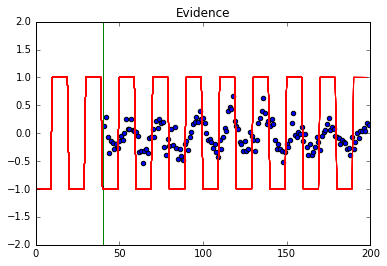

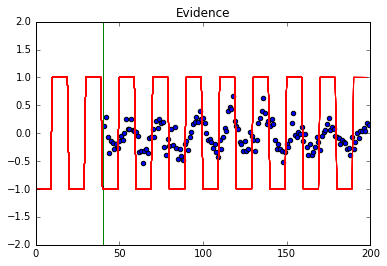

In [31]:
# Run the realtime function with this new classifier object
try:
    realtime_evidence(input_dir=input_dir,
             train_count=train_count,
             clf_obj=train_SVC,
             incremental_batch=0,
            )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

## 3. Adaptive Real-Time Experiments  <a id="real-time-change"></a>

In many real-time experiments, the goal is to change brain function via neurofeedback. For instance, neural representations might change because the experiment trains participants to use different parts of their brain to process a stimulus. In such cases, a classifier trained at the start of the experiment will be wrong by the end of the experiment because the underlying feature space across voxels in the brain has changed. There are algorithms that can be used in these cases, which allow the model fit to be updated as new training examples come in. This can also be used to refine your model with more training data even if the underlying features are stable. 

This approach to dynamically training classifiers is called incremental or online learning and [sklearn](http://scikit-learn.org/stable/modules/scaling_strategies.html#incremental-learning) has a number of classifiers that allow this. Below we specify one classifier with this functionality. First we will run it without incremental updating as a baseline. 

Beware: The initialization of these functions can have a dramatic effect on performance, which you can evaluate by using a random seed.

In [32]:
def train_incremental(training_data,
                      training_labels,
                      parameters=None,
                     ):
    
    all_classes = np.array([1, 2])  # Need to say all the labels, in case you want to test out of sample
    
    # Get the clf
    if parameters is None:
        # Create the linear if it hasn't already been passed in by parameters
        clf = linear_model.SGDClassifier()
    else:
        clf = parameters  # Pull out the classifier
        
    # Fit the training data (either initializing the clf or updating it)    
    clf.partial_fit(training_data,
                    training_labels,
                    classes=all_classes,
                   )
    
    return clf

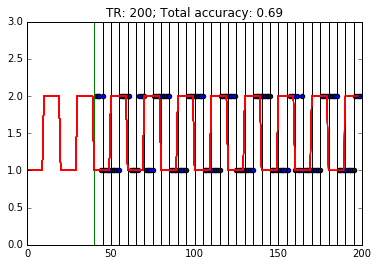

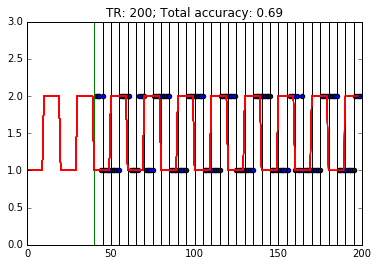

In [36]:
try:
    np.random.seed(0)
    realtime(input_dir=input_dir,
             train_count=train_count,
             clf_obj=train_incremental,
             incremental_batch=5,
            )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

Now that we have run the classifier with static weights, we can try dynamically updating the classifier as we acquire more data. This is accomplished by telling realtime how often you want to update (here, after every additional 20 TRs). The *incremental_batch* variable specifies how many TRs are used in each batch of training

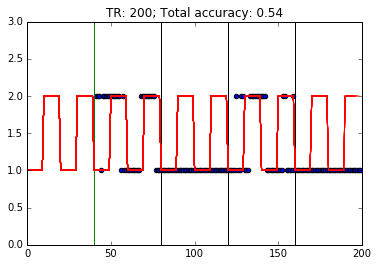

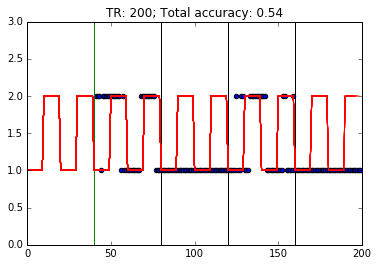

In [37]:
try:
    np.random.seed(0)
    realtime(input_dir=input_dir,
                   train_count=train_count,
                   clf_obj=train_incremental,
                   incremental_batch=40,
                  )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

**Exercise 6:**<a id="ex6"></a> Play around with the size of the batch that you will use to re-train the model. What are the advantages of using a small vs. a large batch? What batch size that you tried works best and why?

**A:** A small batch size works well for error manifolds with lots of local maxima/minima,where the somewhat noisier gradient calculated using the reduced number of samples can jerk the model out of local minima into a region that hopefully is more optimal. By contrast, larger batch sizes have less noisy gradients, which tend to perform better on less convoluted error surfaces. Also, small batch sizes update more frequently during online learning, which gets training data into your model more quickly.

The best performance I observed used a batch size of 5, presumably because it balances this tradeoff of noisy/more frequent updates.

So now that we have a classifier that can update its classifier weights, we can make a simulation of the data changing part way through the experiment. The *generate_data.py* script is currently set up to allow this with a few parameter changes.

**Exercise 7:**<a id="ex7"></a> Generate a new set of data where the brain areas that discriminate between conditions switches halfway through the run (Hint: look at the parameters in *generate_data.py*).

In [42]:
# Run the generate_data function
!sbatch run_generate_data.sh

Submitted batch job 1344518


**Exercise 8:**<a id="ex8"></a> Run a real-time analysis on this new dataset with and without incremental learning (using the optimal results from above) and compare the results. 

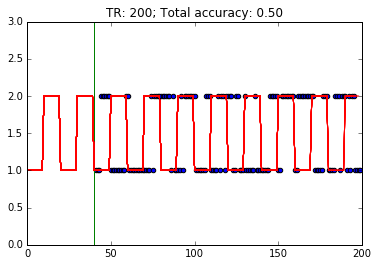

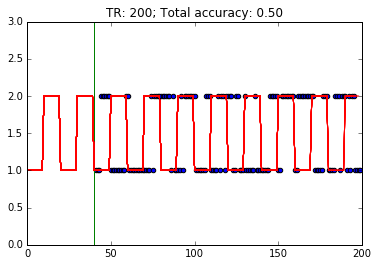

In [43]:
# Without incremental learning. Note that performance trails off in the last half of the experiment
try:
    realtime(input_dir=input_dir,
             train_count=train_count,
             clf_obj=train_SVC,
             incremental_batch=0,
            )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

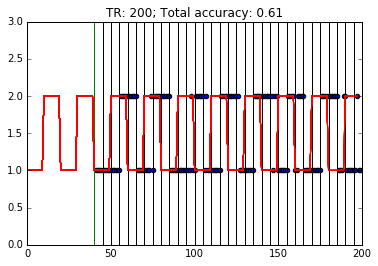

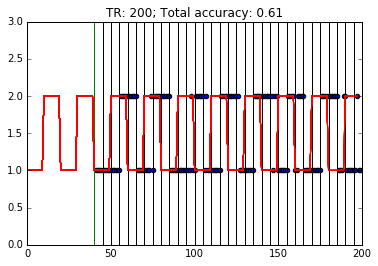

In [44]:
# With incremental learning

try:
    np.random.seed(0)
    realtime(input_dir=input_dir,
             train_count=train_count,
             clf_obj=train_incremental,
             incremental_batch=5,
            )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

**Novel contribution:**<a id="novel"></a> Be creative and make one new discovery by adding an analysis, visualization, or optimization.

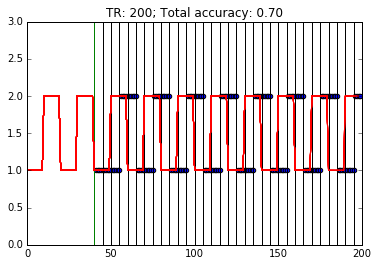

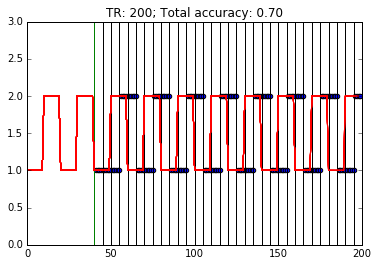

In [50]:
#Try to improve SGD performance on swith_ROI dataset by fiddling with parameters
def train_incremental(training_data,
                      training_labels,
                      parameters=None
                     ):
    
    all_classes = np.array([1, 2])  # Need to say all the labels, in case you want to test out of sample
    
    # Create the linear SGD
    clf = linear_model.SGDClassifier(alpha=.01, penalty='l2')
        
    # Fit the training data (either initializing the clf or updating it)    
    clf.partial_fit(training_data,
                    training_labels,
                    classes=all_classes,
                   )
    
    return clf

try:
    np.random.seed(0)
    realtime(input_dir=input_dir,
             train_count=train_count,
             clf_obj=train_incremental,
             incremental_batch=5,
            )
except Exception as err:
    file_observer.stop()
    print("Exception: {}".format(err))

By modifying the penalty and alpha parameters, performance on the swtich_ROI dataset goes from 0.61 to 0.70, which is a modest improvement.